In [1]:
import pandas as pd

data = pd.read_excel("Данные 1.xlsx")
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data.sort_values(by="DATE",inplace=True)
data.drop(["Unnamed: 0","DATE"],axis=1,inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

C:\Users\anton\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\anton\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ALRS,ROLO,ISKJ,GAZP,LSRG,PIKK,SBER,MOEX,MGNT,GCHE
0,0.013102,-0.012078,0.001335,-0.003099,0.078053,-0.005079,-0.006239,0.045146,-0.071908,0.037924
1,-0.062792,-0.021601,0.054785,-0.015193,-0.012238,-0.010521,0.010576,0.049931,-0.069557,0.022032
2,-0.010933,-0.023452,0.009813,-0.031911,0.023256,0.006003,0.022033,-0.027305,0.027750,-0.046118
3,-0.078282,-0.006166,-0.033670,0.023590,0.001613,-0.003150,0.006485,-0.030803,0.003764,0.048348
4,0.040595,-0.020534,0.062573,0.062786,0.000000,-0.012442,-0.065311,-0.056681,0.094780,-0.033898


In [2]:
train_data = data[:len(data)//2]
test_data = data[len(data)//2:]

In [3]:
import numpy as np

cov_matrix = train_data.cov()
test_cov = test_data.cov()
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# Сортировка собственных значений и векторов по убыванию
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [4]:
def online_gradient_descent(R_generator, b, I_feat, u_list, max_iters=100):
    """
    Выполняет онлайн-градиентный спуск с проекцией для минимизации:
        min sum_{j=1}^{N} ( <g_j, μ> )^2,  при условии <I_hat, μ> = 1
    
    Аргументы:
      R_generator  - функция, возвращающая случайное наблюдение R (вектор размерности d)
      b            - вектор b (размерность d)
      I_feat       - базовый вектор признаков (например, вектор единиц, размерность d)
      u_list       - список из m векторов (например, первые m собственных векторов)
      max_iters    - число итераций (по умолчанию 30)
    
    Возвращает:
      μ       - финальный вектор параметров (размер m+1)
      errors  - список значений ошибки на каждой итерации
    """
    m = len(u_list)
    # Формируем вектор для проекции: I_hat = [<I_feat, I_feat>, <u_list[0], I_feat>, ..., <u_list[m-1], I_feat>]
    I_hat = np.zeros(m + 1)
    I_hat[0] = np.dot(I_feat, I_feat)
    for i in range(m):
        I_hat[i+1] = np.dot(u_list[i], I_feat)
    
    # Нормировочная константа, чтобы обеспечить условие <I_hat, μ> = 1
    S = I_hat.sum()
    mu = np.ones(m + 1) / S
    errors = []
    error = 0
    
    for j in range(max_iters):
        R = R_generator()       # получаем наблюдение R (размер d)
        diff = R - b            # разница R - b
        
        # Формируем вектор градиента g:
        # g[0] = <I_feat, R-b>, g[i+1] = <u_list[i], R-b>
        g = np.zeros(m + 1)
        g[0] = np.dot(I_feat, diff)
        for i in range(m):
            g[i+1] = np.dot(u_list[i], diff)
        
        # Выбираем шаг h 
        h = 0.01 / (j + 1)
        grad_scale = np.dot(g, mu)
        # Градиентный шаг:
        v = mu - h * grad_scale * g
        # Проекционный шаг, чтобы обеспечить <I_hat, μ> = 1:
        proj = (1 - np.dot(I_hat, v)) / np.dot(I_hat, I_hat)
        mu = v + proj * I_hat
        
        # Ошибка на текущей итерации:
        err = np.dot(g, mu) ** 2
        error += err
        errors.append(error/(j+1))
        print(f"Epoch: {j + 1}, error: {err}")
    
    return mu, errors

In [5]:
m = 4  # число выбранных собственных векторов
# Размерность (количество признаков) определяется по количеству строк в eigenvectors
d = eigenvectors.shape[0]
# Вектор I_feat – базовый вектор признаков (например, вектор единиц)
I_feat = np.ones(d)
# Список u_list – первые m собственных векторов
u_list = [eigenvectors[:, i] for i in range(m)]
# Вектор b (например, вектор единиц той же размерности)
b = np.ones(d)
    
# Генератор наблюдений R: функция, возвращающая случайный вектор размерности d
def R_gen():
    return np.random.rand(d)

In [15]:
mu, errors = online_gradient_descent(R_gen, b, I_feat, u_list, max_iters=20)

Epoch: 1, error: 0.3071804474971308
Epoch: 2, error: 0.19186938630206773
Epoch: 3, error: 0.12697999707951904
Epoch: 4, error: 0.27611179106518025
Epoch: 5, error: 0.2718066997800074
Epoch: 6, error: 0.2857352939325742
Epoch: 7, error: 0.20829613100423214
Epoch: 8, error: 0.15849629942941165
Epoch: 9, error: 0.20309690043799317
Epoch: 10, error: 0.08917422467371255
Epoch: 11, error: 0.0775396806429943
Epoch: 12, error: 0.4336916132986058
Epoch: 13, error: 0.14586269006513783
Epoch: 14, error: 0.2940291105447902
Epoch: 15, error: 0.29998428992679604
Epoch: 16, error: 0.11034167462910613
Epoch: 17, error: 0.229607700771359
Epoch: 18, error: 0.2768248832955252
Epoch: 19, error: 0.3727424848738218
Epoch: 20, error: 0.1989854576928509


In [16]:
x = mu[0] * I_feat.copy()
for i in range(m):
    x += mu[i + 1] * u_list[i]
    
print("\nФинальный вектор параметров μ:", mu)
print("Результирующий портфельный вектор x:", x)
print("Риск портфеля", np.dot(np.dot(cov_matrix,x),x))
print("Сумма x", x.sum())


Финальный вектор параметров φ: [0.10503186 0.10184307 0.10469713 0.10456146 0.10745559]
Результирующий портфельный вектор x: [ 0.04632825  0.21695534 -0.01082303  0.07043276  0.15141794  0.0795362
  0.16422495  0.14683173  0.03321112  0.10188475]
Риск портфеля 0.0009476408236382518
Сумма x 0.9999999999999998


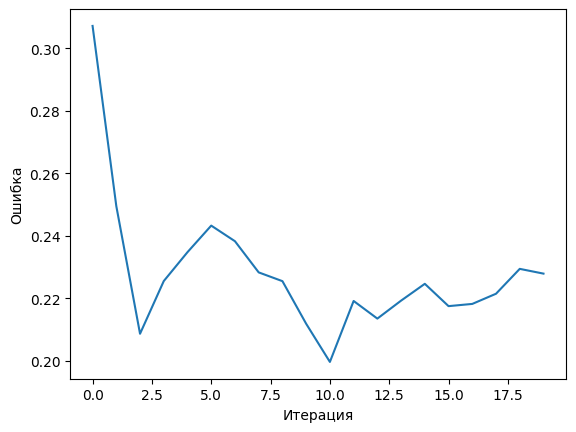

In [17]:
import matplotlib.pyplot as plt

plt.xlabel("Итерация")
plt.ylabel("Ошибка")
plt.plot(errors)
plt.show()